This is the corresponding code for the [01: Attention is All You Need](https://yyzhang2025.github.io/100-AI-Papers/posts/01-attention.html).


In [26]:
# ! pip uninstall -y datasets
# ! pip install datasets==3.6.0

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import math

import einops

## Helper Function

In [28]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


def expand_tensor(tensor,target_dim, head=True):
    """
    Expands the tensor's dimensions until it reaches the target number of dimensions.
    tensor (torch.Tensor): The input tensor to expand.
    target_dim (int): Desired number of dimensions.
    head (bool): If True, adds dimensions to the front;
                    if False, adds to the tail (end).
    """

    while tensor.ndim < target_dim:
        tensor = tensor.unsqueeze(0) if head else tensor.unsqueeze(-1)

    return tensor

def create_causal_mask(seq_len_q, seq_len_k = None):
    """
    Create a causal mask for the attention mechanism.
    seq_len_q: Length of the query sequence
    seq_len_k: Length of the key sequence
    """
    if seq_len_k is None:
        seq_len_k = seq_len_q

    mask = torch.triu(torch.ones(seq_len_q, seq_len_k), diagonal=1).bool()

    return mask.unsqueeze(0)  # (1, 1, seq_len_q, seq_len_k)

def create_padding_mask(x, padding_idx=0):
    """
    Create a padding mask for the attention mechanism.
    seq_len: Length of the sequence
    padding_idx: Index used for padding (default is 0)
    """
    mask = (x == padding_idx) # (seq_len)
    mask = expand_tensor(mask, 3) # (1, 1, seq_len)

    return mask  # (1, 1, seq_len, seq_len)

In [29]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    src_vocab_size: int = 16000
    tgt_vocab_size: int = 16000
    max_seq: int = 128

    d_model: int = 512
    d_ff: int = 2048
    num_heads: int = 8
    num_layers: int = 6
    dropout: float = 0.1

    eps: float = 1e-6  # for Layer Normalization


DEVICE = get_device()
print("Using device:", DEVICE)

Using device: cuda


## Transformer Model Implementation


### Embedding

In [30]:
class WordEmbedding(nn.Module):
    def __init__(self, config: ModelConfig, is_tgt: bool = False):
        super().__init__()

        if is_tgt:
            self.embedding = nn.Embedding(config.tgt_vocab_size, config.d_model)
        else:
            self.embedding = nn.Embedding(config.src_vocab_size, config.d_model)

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        return self.embedding(x)


class PositionalEmbedding(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        pos_index = torch.arange(config.max_seq).unsqueeze(1)  # (max_seq, 1)

        div_term = torch.exp(
            torch.arange(0, config.d_model, 2)  / config.d_model * -math.log(10000.0)
        )

        pe = torch.zeros(config.max_seq, config.d_model)  # (max_seq, d_model)
        pe[:, 0::2] = torch.sin(pos_index * div_term)
        pe[:, 1::2] = torch.cos(pos_index * div_term)

        pe = expand_tensor(pe, 3) # (1, max_seq, d_model)

        pe.requires_grad = False
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        return self.pe[:, :seq_len, :]  # (1, seq_len, d_model)


class Embedding(nn.Module):
    def __init__(self, config: ModelConfig, is_tgt: bool = False):
        super().__init__()
        self.word_embedding = WordEmbedding(config, is_tgt)
        self.positional_embedding = PositionalEmbedding(config)

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        word_emb = self.word_embedding(x)
        pos_emb = self.positional_embedding(word_emb)
        return word_emb + pos_emb  # (batch_size, seq_len, d_model)

### Layer Normalization

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma + \epsilon} \cdot \gamma + \beta
$$


In [31]:
class LayerNormalization(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.eps = config.eps

        self.gamma = nn.Parameter(torch.ones(config.d_model))  # (d_model,)
        self.beta = nn.Parameter(torch.zeros(config.d_model))  # (d_model,)

    def _compute_mean_std(self, x):
        """
        Compute mean and standard deviation for the input tensor x
        On the last dimension (features)
        x: (batch_size, seq_len, d_model)
        Output:
            mean: (batch_size, seq_len, 1)
            std: (batch_size, seq_len, 1)
        """
        mean = x.mean(dim=-1, keepdim=True)

        # Numerail Stability
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        std = torch.sqrt(var + self.eps)  # manual epsilon for extra safety
        return mean, std

    def forward(self, x):
        mean, std = self._compute_mean_std(x)
        normalized_x = (x - mean) / std  # Avoid division by zero

        return normalized_x * self.gamma + self.beta  # (batch_size, seq_len, d_model)

### Feedforward Neural Network


In [32]:
class FFN(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.ln1 = nn.Linear(config.d_model, config.d_ff, bias=True)
        self.ln2 = nn.Linear(config.d_ff, config.d_model, bias=True)

    def forward(self, x):
        x = F.relu(self.ln1(x))  # Apply ReLU activation
        x = self.ln2(x)  # Linear transformation
        return x  # (batch_size, seq_len, d_model)

### Attention

In [33]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Scaled Dot-Product Attention
    q: (batch_size, num_heads, seq_len_q, d_k)
    k: (batch_size, num_heads, seq_len_k, d_k)
    v: (batch_size, num_heads, seq_len_v, d_v)
    mask: (batch_size, 1, seq_len_q, seq_len_k) or None
    """
    assert q.ndim== k.ndim == v.ndim ==  4, "Query, Key, Value must has form (batch_size, num_heads, seq_len, d)"
    assert q.shape[-1] == k.shape[-1], "Query, Key must have feature dimension, which mean d_k == d_q"

    d_k = k.shape[-1]
    scores = einops.einsum(
        q,
        k,
        "batch heads seq_len_q d_k, batch heads seq_len_k d_k -> batch heads seq_len_q seq_len_k",
    )

    scores = scores / math.sqrt(d_k)  # Scale the scores
    if mask is not None:
        scores = scores.masked_fill(mask, float("-inf"))  # Apply mask if provided

    scores = F.softmax(scores, dim=-1)  # Apply softmax to get attention weights

    output = einops.einsum(
        scores,
        v,
        "batch heads seq_len_q seq_len_k, batch heads seq_len_k d_v -> batch heads seq_len_q d_v",
    )

    return output

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        assert (
            config.d_model % config.num_heads == 0
        ), "d_model must be divisible by num_heads"

        self.num_heads = config.num_heads
        self.d_k = config.d_model // config.num_heads  # Dimension of each head

        self.qkv_proj = nn.Linear(
            config.d_model, config.d_model * 3, bias=True
        )  # (d_model, d_model * 3)

        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=True)

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len_q, seq_len_k) or None
        """
        batch_size, seq_len, _ = x.size()

        q, k, v = map(
            lambda t: einops.rearrange(
                t,
                "batch seq_len (heads d_k) -> batch heads seq_len d_k",
                heads=self.num_heads,
            ),
            self.qkv_proj(x).chunk(3, dim=-1),
        )  # (batch, num_heads, seq_len, d_k)

        # Compute attention
        attn_output = scaled_dot_product_attention(q, k, v, mask)

        # Rearrange back to (batch_size, seq_len, d_model)
        attn_output = einops.rearrange(
            attn_output,
            "batch heads seq_len d_v -> batch seq_len (heads d_v)",
            heads=self.num_heads,
        )

        output = self.out_proj(attn_output)  # (batch_size, seq_len, d_model)

        return output  # (batch_size, seq_len, d_model)

In [35]:
class CrossAttention(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        assert (
            config.d_model % config.num_heads == 0
        ), "d_model must be divisible by num_heads"

        self.num_heads = config.num_heads
        self.d_k = config.d_model // config.num_heads


        self.q_proj = nn.Linear(
            config.d_model, config.d_model, bias=True
        )  # (d_model, d_model)
        self.k_proj = nn.Linear(config.d_model, config.d_model, bias=True)
        self.v_proj = nn.Linear(config.d_model, config.d_model, bias=True)

        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=True)

    def forward(self, query, key, value, mask=None):
        """
        query: (batch_size, seq_len_q, d_model)
        key: (batch_size, seq_len_k, d_model)
        value: (batch_size, seq_len_v, d_model)
        mask: (batch_size, 1, seq_len_q, seq_len_k) or None
        """
        batch_size = query.size(0)

        q = einops.rearrange(
            self.q_proj(query),
            "batch seq_len_q (heads d_k) -> batch heads seq_len_q d_k",
            heads=self.num_heads,
        )

        k = einops.rearrange(
            self.k_proj(key),
            "batch seq_len_k (heads d_k) -> batch heads seq_len_k d_k",
            heads=self.num_heads,
        )

        v = einops.rearrange(
            self.v_proj(value),
            "batch seq_len_v (heads d_v) -> batch heads seq_len_v d_v",
            heads=self.num_heads,
        )

        # Compute attention
        attn_output = scaled_dot_product_attention(q, k, v, mask)

        # Rearrange back to (batch_size, seq_len_q, d_model)
        attn_output = einops.rearrange(
            attn_output,
            "batch heads seq_len_q d_v -> batch seq_len_q (heads d_v)",
            heads=self.num_heads,
        )

        return self.out_proj(attn_output)  # (batch_size, seq_len_q, d_model)

### Encoder Block


In [36]:
class EncoderBlock(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.self_attn = MultiHeadAttention(config)
        self.ffn = FFN(config)
        self.ln1 = LayerNormalization(config)
        self.ln2 = LayerNormalization(config)

    def forward(self, x, src_mask=None):
        out = self.self_attn(x, src_mask)  # (batch_size, seq_len, d_model)
        out = self.ln1(out + x)  # Add & Norm
        out = self.ffn(out)  # (batch_size, seq_len, d_model
        out = self.ln2(out + x)  # Add & Norm

        return out  # (batch_size, seq_len, d_model

### Decoder Block

In [37]:
class DecoderBlock(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.self_attn = MultiHeadAttention(config)
        self.cross_attn = CrossAttention(config)
        self.ffn = FFN(config)
        self.ln1 = LayerNormalization(config)
        self.ln2 = LayerNormalization(config)
        self.ln3 = LayerNormalization(config)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        out = self.self_attn(x, tgt_mask)  # Self-attention
        out = self.ln1(out + x)  # Add & Norm

        out = self.cross_attn(out, enc_output, enc_output, src_mask)  # Cross-attention
        out = self.ln2(out + x)  # Add & Norm

        out = self.ffn(out)  # Feedforward
        out = self.ln3(out + x)  # Add & Norm

        return out  # (batch_size, seq_len, d_model)

### Encoder & Decoder

In [38]:
class Encoder(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.embedding = Embedding(config)
        self.layers = nn.ModuleList(
            [EncoderBlock(config) for _ in range(config.num_layers)]
        )
        self.ln = LayerNormalization(config)

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len)
        """
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)

        x = self.ln(x)  # Final Layer Normalization
        return x  # (batch_size, seq_len, d_model)


class Decoder(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.embedding = Embedding(config, is_tgt=True)
        self.layers = nn.ModuleList(
            [DecoderBlock(config) for _ in range(config.num_layers)]
        )
        self.ln = LayerNormalization(config)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        """
        x: (batch_size, seq_len)
        enc_output: (batch_size, seq_len, d_model)
        """
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask=src_mask, tgt_mask=tgt_mask)
        x = self.ln(x)  # Final Layer Normalization
        return x  # (batch_size, seq_len, d_model)

### Transformer Model

In [39]:
class Transformer(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.encoder = Encoder(config)
        self.decoder = Decoder(config)
        self.output_layer = nn.Linear(config.d_model, config.tgt_vocab_size)

        self._tie_weight()

    def _tie_weight(self):
        """
        Tie the weights of the output layer with the embedding layer.
        This is a common practice in Transformer models to reduce the number of parameters.
        """
        self.output_layer.weight = (
            self.decoder.embedding.word_embedding.embedding.weight
        )

    def encode(self, x, src_mask = None):
        enc_output = self.encoder(x, src_mask)
        return enc_output

    def decode(self, enc_output, tgt, src_mask, tgt_mask):
        dec_output = self.decoder(
            tgt, enc_output, src_mask, tgt_mask
        )

        return dec_output

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = expand_tensor(src, 2) # (B, Src_Seq_len)
        tgt = expand_tensor(tgt, 2) # (B, Tgt_Seq_len)

        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(enc_output, tgt, src_mask, tgt_mask)
        logits = self.output_layer(dec_output)

        return logits

### Dummy Test

In [40]:
config = ModelConfig()
transformer = Transformer(config).to(DEVICE)

src = torch.randint(
    0,config.src_vocab_size, (32, 10)
).to(DEVICE)  # (batch_size, src_seq_len
tgt = torch.randint(
    0, config.tgt_vocab_size, (32, 15)
).to(DEVICE)  # (batch_size, tgt_seq_len

causal_mask = create_causal_mask(tgt.size(1), tgt.size(1))
causal_mask = causal_mask.to(DEVICE)

output = transformer(src, tgt, tgt_mask=causal_mask)

assert output.shape == (*tgt.size(), config.tgt_vocab_size)

## Dataset Preparation


In [41]:
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
from tokenizers.normalizers import Sequence, NFKC
from tokenizers.pre_tokenizers import Whitespace
import os

In [42]:
def save_dataset(dataset, file_prefix, src='en', tgt='zh', debug=True):
    assert file_prefix is not None, "file_prefix must be set"

    if debug:
        dataset = dataset[:len(dataset) // 100]

    src_file_name = file_prefix + '_src' + ".txt"
    tgt_file_name = file_prefix + '_tgt' + ".txt"

    if os.path.exists(src_file_name) and os.path.exists(tgt_file_name):
        print(f"{src_file_name}, {tgt_file_name} already exists")
        return

    with open(src_file_name, 'w', encoding='utf-8') as src_f, open(tgt_file_name, 'w', encoding='utf-8') as tgt_f:
        for example in dataset:
            src_f.write(example[src].strip() + "\n")
            tgt_f.write(example[tgt].strip() + "\n")

    print(f"{src_file_name}, {tgt_file_name} saved")

In [43]:
# dataset = load_dataset(
#     "iwslt2017",
#     "iwslt2017-en-zh",
#     download_mode="force_redownload",
#     trust_remote_code=True,
# )

# train_dataset = dataset['train']['translation']
# test_dataset = dataset['test']['translation']

# save_dataset(train_dataset, file_prefix='train')
# save_dataset(test_dataset, file_prefix='test')

iwslt2017.py: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

en-zh.zip:   0%|          | 0.00/27.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/231266 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8549 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/879 [00:00<?, ? examples/s]

train_src.txt, train_tgt.txt already exists
test_src.txt, test_tgt.txt already exists


### Train BPE Tokenizer


In [44]:
def load_or_train_bpe_tokenizer(vocab_size, ln, save_name = "bpe.json"):
    save_path = ln+"_" + save_name

    ### HARD Coded
    if ln == 'zh':
        corpus_file = 'train_tgt.txt'
    elif ln == 'en':
        corpus_file = 'train_src.txt'

    if os.path.exists(save_path):
        print(f"Loading tokenizer from {save_path}")
        tokenizer = Tokenizer.from_file(save_path)
        return tokenizer
    else:
        tokenizer = Tokenizer(models.BPE())
        tokenizer.normalizer = NFKC()
        tokenizer.pre_tokenizer = Whitespace()

        trainer = trainers.BpeTrainer(
            vocab_size=vocab_size, special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
        )

        tokenizer.train([corpus_file], trainer)
        tokenizer.save(save_path)
        print(f"Saved tokenizer to {save_path}")

        return tokenizer

### Define Dataset

In [45]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(
        self,
        file_prefix,
        tokenizer_src,
        tokenizer_tgt,
        seq_len=128,
        is_debug=True,
    ):

        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.seq_len = seq_len
        self.is_debug = is_debug

        self.pad_id_src = tokenizer_src.token_to_id("<pad>") or 0
        self.pad_id_tgt = tokenizer_tgt.token_to_id("<pad>") or 0

        self.sos_id = tokenizer_tgt.token_to_id("<s>") or 1
        self.eos_id = tokenizer_tgt.token_to_id("</s>") or 2

        self.source_texts, self.target_texts = self._load_text_pairs(file_prefix)


    def _load_text_pairs(self, file_prefix):
        src_path = file_prefix + "_src.txt"
        tgt_path = file_prefix + "_tgt.txt"

        assert os.path.exists(src_path), f"Source file not found: {src_path}"
        assert os.path.exists(tgt_path), f"Target file not found: {tgt_path}"

        with open(src_path, encoding="utf-8") as f_src, open(tgt_path, encoding="utf-8") as f_tgt:
            src_lines = [line.strip() for line in f_src if line.strip()]
            tgt_lines = [line.strip() for line in f_tgt if line.strip()]

        assert len(src_lines) == len(tgt_lines), "Mismatched number of lines in source and target files"
        if self.is_debug:
            src_lines = src_lines[:1000]
            tgt_lines = tgt_lines[:1000]
        return src_lines, tgt_lines


    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        src_text = self.source_texts[idx]
        tgt_text = self.target_texts[idx]

        src_ids = self._process_source(src_text)
        tgt_ids, decoder_ids = self._process_target(tgt_text)

        assert decoder_ids.size(0) == self.seq_len
        assert tgt_ids.size(0) == self.seq_len
        assert src_ids.size(0) == self.seq_len

        return {
            "encoder_input_ids": src_ids,
            "decoder_input_ids": decoder_ids,
            "labels": tgt_ids,
            "encoder_mask": create_padding_mask(src_ids, self.pad_id_src),
            "decoder_mask": create_causal_mask(decoder_ids.size(0), decoder_ids.size(0))
            & create_padding_mask(decoder_ids, self.pad_id_tgt),
        }

    def _process_source(self, text: str) -> torch.Tensor:
        token_ids = self.tokenizer_src.encode(text).ids
        token_ids = self._pad_or_truncate(token_ids, self.seq_len, self.pad_id_src)
        return torch.tensor(token_ids, dtype=torch.int64)

    def _process_target(self, text: str):
        token_ids = self.tokenizer_tgt.encode(text).ids

        tgt_ids = token_ids[: self.seq_len - 1] + [self.eos_id]
        tgt_ids = self._pad_or_truncate(tgt_ids, self.seq_len, self.pad_id_tgt)

        decoder_ids = [self.sos_id] + token_ids[: self.seq_len - 1]
        decoder_ids = self._pad_or_truncate(decoder_ids, self.seq_len, self.pad_id_tgt)

        return (
            torch.tensor(tgt_ids, dtype=torch.int64),
            torch.tensor(decoder_ids, dtype=torch.int64),
        )

    def _pad_or_truncate(self, ids, length, pad_id):
        return ids[:length] + [pad_id] * (length - len(ids))

## Training Procedure


### Loss Function with Label Smoothing


### Adam Optimizer


$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}}+\epsilon}$$

where:

\begin{align*}
\hat{m}*{t,i} &= \frac{m*{t,i}}{1-\beta*1^t} \\
\hat{v}_{t,i} &= \frac{v\_{t,i}}{1-\beta_2^t}
\end{align_}


In [46]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_squares = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0

    def zero_grad(self):
        for p in self.model_params:
            p.grad = None

    @torch.no_grad()
    def step(self):
        self.n_steps += 1  # increment ONCE per step

        for p, m, v in zip(self.model_params, self.avg_grads, self.avg_squares):
            if p.grad is None:
                continue

            # Update moving averages
            m.mul_(self.beta_1).add_(p.grad, alpha=1 - self.beta_1)
            v.mul_(self.beta_2).addcmul_(p.grad, p.grad, value=1 - self.beta_2)

            # Bias correction
            m_hat = m / (1 - self.beta_1**self.n_steps)
            v_hat = v / (1 - self.beta_2**self.n_steps)

            # Parameter update
            p.addcdiv_(m_hat, v_hat.sqrt() + self.eps, value=-self.lr)

In [47]:
class LRScheduler:
    def __init__(self, optimizer, d_model: int, warmup_steps: int = 4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def _compute_lr(self, step: int) -> float:
        scale = self.d_model ** -0.5
        return scale * min(step ** -0.5, step * self.warmup_steps ** -1.5)

    def step(self):
        self.step_num += 1
        new_lr = self._compute_lr(self.step_num)
        self.optimizer.lr = new_lr  # update custom optimizer’s lr

In [48]:
class LabelSmoothing(nn.Module):
    def __init__(self, config: ModelConfig, smoothing=0.1, ignore_index: int = 0):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.vocab_size = config.tgt_vocab_size
        self.ignore_index = ignore_index
        self.eps = smoothing / (self.vocab_size - 1)

    def forward(self, logits, target):
        """
        logits: (batch_size, seq_len, vocab_size)
        target: (batch_size, seq_len)
        """
        if logits.ndim == 3:
            logits = logits.view(-1, self.vocab_size)

        if target.ndim == 2:
            target = target.view(-1)

        # Mask padding tokens
        mask = target != self.ignore_index
        target = target[mask]
        logits = logits[mask]

        # Compute log-probabilities
        log_probs = F.log_softmax(logits, dim=-1)

        # Create smoothed one-hot labels
        true_dist = torch.full_like(log_probs, self.eps)
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)


        loss = F.kl_div(log_probs, true_dist, reduction="batchmean")

        return loss

## Training Loop


In [49]:
from tqdm.autonotebook import tqdm

def train_step(
    model,
    optimizer,
    criterion,
    data,
):
    model.train()


    encoder_input_ids = data["encoder_input_ids"].to(DEVICE)
    decoder_input_ids = data["decoder_input_ids"].to(DEVICE)
    enc_mask = data["encoder_mask"].to(DEVICE)
    dec_mask = data["decoder_mask"].to(DEVICE)

    labels = data["labels"].to(DEVICE)

    # Forward pass
    logits = model(encoder_input_ids, decoder_input_ids, src_mask=enc_mask, tgt_mask=dec_mask)

    # Compute loss # Debugging line
    loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

    # Clear all the graidnet information
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.item()  # Return the loss value for logging


def train(model, dataset, optimizer, criterion, num_epochs=10):
    model.train()

    losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in tqdm(dataset, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            loss = train_step(model, optimizer, criterion, batch)
            total_loss += loss
            losses.append(loss)

        avg_loss = total_loss / len(dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return losses

In [50]:
import torch.nn.init as init

def init_transformer(module):
    if isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        init.xavier_uniform_(module.weight)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

In [59]:
# Initialize model, optimizer, and loss function
config = ModelConfig()

model = Transformer(config)
model.apply(init_transformer)
model = model.to(DEVICE)

src_tokenizer = load_or_train_bpe_tokenizer(vocab_size=config.src_vocab_size, ln = 'en')
tgt_tokenizer = load_or_train_bpe_tokenizer(vocab_size=config.tgt_vocab_size, ln = 'zh')

translation_dataset = TranslationDataset(
    file_prefix='train',
    tokenizer_src=src_tokenizer,
    tokenizer_tgt=tgt_tokenizer,
    seq_len=config.max_seq,
    is_debug=True,
)
train_dataloader = torch.utils.data.DataLoader(
    translation_dataset,
    batch_size=64,
    shuffle=True,              # shuffle for training
    num_workers=2,             # or 0 if debugging or on Windows
    pin_memory=True,           # for faster GPU transfer (optional)
    drop_last=False,           # whether to drop the last incomplete batch
)

optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = LRScheduler(optimizer, d_model=config.d_model, warmup_steps=40)\

criterion = LabelSmoothing(config, ignore_index=0).to(DEVICE)

losses = train(model, train_dataloader, optimizer, criterion, num_epochs=10)

Loading tokenizer from en_bpe.json
Loading tokenizer from zh_bpe.json


Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10, Loss: 8.1815


Epoch 2/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10, Loss: 7.9169


Epoch 3/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10, Loss: 7.8073


Epoch 4/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10, Loss: 7.7344


Epoch 5/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10, Loss: 7.6672


Epoch 6/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10, Loss: 7.6029


Epoch 7/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10, Loss: 7.5370


Epoch 8/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10, Loss: 7.4759


Epoch 9/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10, Loss: 7.4120


Epoch 10/10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/10, Loss: 7.3406


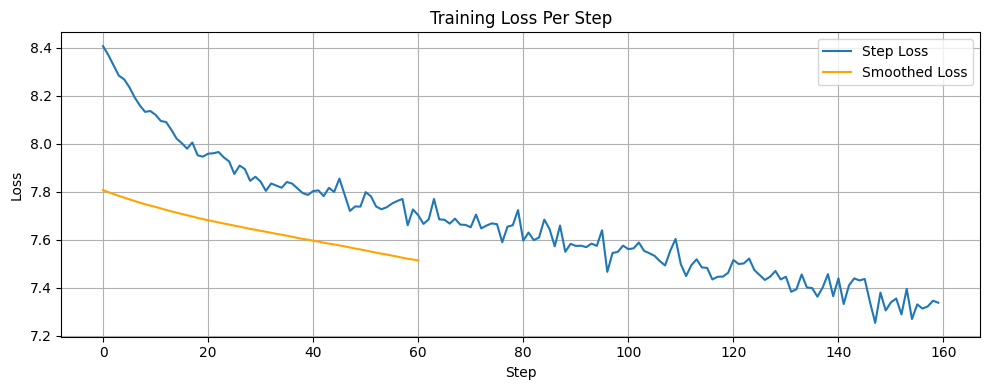

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(values, window_size=100):
    if len(values) < window_size:
        return values  # skip smoothing if not enough data
    kernel = np.ones(window_size) / window_size
    return np.convolve(values, kernel, mode='valid')

def plot_loss_curve(losses, window_size=100):
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label="Step Loss")
    smoothed = smooth_curve(losses, window_size)
    plt.plot(range(len(smoothed)), smoothed, label="Smoothed Loss", color="orange")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Per Step")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_curve(losses)

In [61]:
english = "Hi, how are you, This is test"
# pad engligh
src_ids = src_tokenizer.encode(english).ids + [src_tokenizer.token_to_id('<pad>')] * (128 - len(src_tokenizer.encode(english).ids))
src_ids = torch.tensor(src_ids, dtype = torch.int64)
src_mask = create_padding_mask(src_ids, padding_idx=0)

src_ids = expand_tensor(src_ids, 2)

decoder_input = torch.tensor(tgt_tokenizer.token_to_id('<s>'), dtype = torch.int64).unsqueeze(0).unsqueeze(0)

src_ids = src_ids.to(DEVICE)
decoder_input = decoder_input.to(DEVICE)
src_mask = src_mask.to(DEVICE)

while decoder_input.size(1) < 128:
    decocer_mask = create_causal_mask(
        decoder_input.size(0), decoder_input.size(0)
    )

    decocer_mask = decocer_mask.to(DEVICE)
    out = model(src_ids, decoder_input, src_mask=src_mask, tgt_mask=decocer_mask)

    _, next_word = torch.max(out[:, -1], dim = -1)

    decoder_input = torch.cat(
        [decoder_input, torch.empty(1, 1).type_as(src_ids).fill_(next_word.item()).to(DEVICE)], dim=1)

    if next_word == tgt_tokenizer.token_to_id('</s>'):
        break

output = tgt_tokenizer.decode(decoder_input[0].tolist())
print(output)

## Appendix

### Visualize Learning Rate

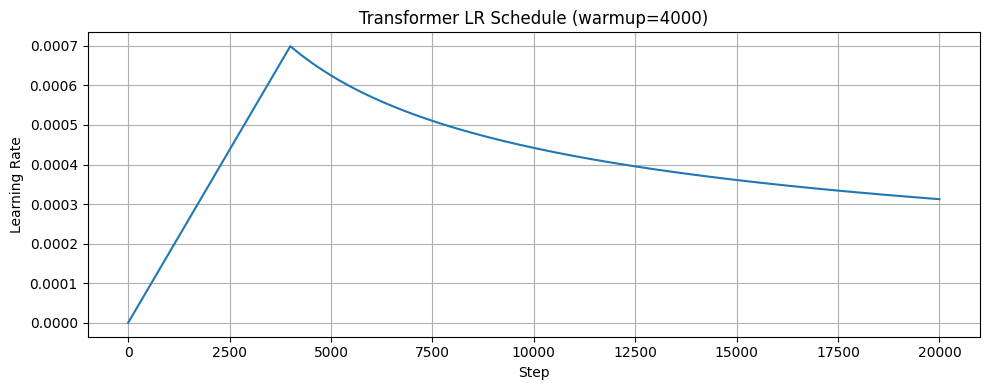

In [62]:
import matplotlib.pyplot as plt


def plot_lr_schedule(scheduler, num_steps=10000):
    lrs = []

    # Save the original step number and restore it later
    original_step = scheduler.step_num

    for _ in range(num_steps):
        scheduler.step()
        lrs.append(scheduler.optimizer.lr)

    # Restore step counter if needed
    scheduler.step_num = original_step

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lrs)
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.title(f"Transformer LR Schedule (warmup={scheduler.warmup_steps})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Dummy optimizer with `.lr` field
class DummyOptimizer:
    def __init__(self):
        self.lr = 0.0

# Create scheduler
optimizer = DummyOptimizer()
scheduler = LRScheduler(optimizer, d_model=512, warmup_steps=4000)

# Plot
plot_lr_schedule(scheduler, num_steps=20000)